<a href="https://colab.research.google.com/github/diviramon/BASSic/blob/master/ML/HighRes_Patch_Ganomaly_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Create Dirs

In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 14.5MB/s 


In [3]:
import shutil
import os
import cv2
import re
import random
from skimage.io import imread 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import pandas as pd
from torch import nn
from torch.autograd import grad
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split, ConcatDataset

from collections import OrderedDict
import time
from tqdm import tqdm

from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils

from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab.patches import cv2_imshow
import pydicom as dcm
from skimage import io, exposure

In [4]:
!rm -r sample_data/
!mkdir data
!mkdir data/train
!mkdir data/train/healthy
!mkdir data/valid
!mkdir data/valid/healthy
!mkdir data/valid/nodule
!mkdir data/test/
!mkdir data/test/healthy
!mkdir data/test/nodule
!mkdir data/patients/
!mkdir output/
!mkdir output/patients/

# Read Image Functions


In [5]:
def read_indiana(file_name, cxr_path, mask_path):
  
  dcm_filename = file_name[3:-4] + '.dcm'

  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255

  # Read in DICOM 
  ds = dcm.dcmread(os.path.join(cxr_path, dcm_filename))
  cxr = ds.pixel_array
  #print(ds.PhotometricInterpretation)
  #cxr = dcm.pixel_data_handlers.util.apply_voi_lut(cxr, ds, index=0)
  cxr = cv2.resize(cxr, (1024, 1024))
  if ds.PhotometricInterpretation == 'MONOCHROME1':
    cxr = 1.0 - cxr * 1./4096
  else:
    cxr = cxr * 1. / 4096
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
  # cxr = exposure.equalize_hist(cxr)*255

  return mask, cxr

In [6]:
def read_nih(file_name, cxr_path, mask_path):
  
  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255
  
  # Read in PNG
  cxr = cv2.imread(os.path.join(cxr_path, file_name))
  cxr = cv2.cvtColor(cxr, cv2.COLOR_BGR2GRAY)
  cxr = cv2.resize(cxr, (1024, 1024)) 
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
  # cxr = exposure.equalize_hist(cxr)*255

  return mask, cxr

In [7]:
def read_jsrt(file_name, cxr_path, mask_path):

  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255

  # Read in IMG
  fname = file_name[:-4] + '.IMG'
  cxr = 1.0 - np.fromfile(os.path.join(cxr_path, fname), dtype='>u2').reshape((2048, 2048))
  cxr = cxr * 1. / 4096
  cxr = cv2.resize(cxr, (1024, 1024)) 
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
  # cxr = exposure.equalize_hist(cxr)*255

  return mask, cxr

# Patching Functions

In [8]:
def crop_patches(image, mask, total_patches, box, image_name, dataset, svpath):
  if dataset == 'indiana':
    patch_extractor = ExtractPatches(image_name, image, mask, box, 64, 32, dataset, svpath)
  else:
    patch_extractor = ExtractPatches(image_name, image, mask, box, 64, 16, dataset, svpath)
  
  lung_area = np.count_nonzero(mask)
  patches = patch_extractor.extract_all_patches()
  total_patches = total_patches + patches

  return total_patches

In [9]:
class ExtractPatches:
    def __init__(self, image_name, image, mask, bbox, patchSize, stride, dataset, out_path):
        self.image = image
        self.out_path = out_path
        self.dataset = dataset
        self.bbox = bbox
        self.annotated = np.copy(image) 
        self.reconstructed = np.empty(image.shape)
        self.reconstructed[:] = np.nan
        self.image_name = image_name
        self.patchSize = patchSize
        self.stride = stride
        self.mask = mask

    def draw_single_patches(self, coords, patch):
      y1 = coords[0] * self.stride
      x1 = coords[1] * self.stride
      y2 = coords[0] * self.stride + self.patchSize
      x2 = coords[1] * self.stride + self.patchSize
      self.annotated = cv2.rectangle(self.annotated,(x1,y1), (x2,y2), (0, 0, 255))
      self.reconstructed[y1:y2, x1:x2] = patch
    
    def extract_single_patches(self, patch):
        croppedPatches = self.image[(patch[0] * self.stride):(patch[0] * self.stride + self.patchSize), 
                               (patch[1] * self.stride):(patch[1] * self.stride + self.patchSize)]
        return croppedPatches

    def no_of_patches(self):
        yNoOfPatches, xNoOfPatches = (int((self.image.shape[1] - self.patchSize) / self.stride + 1),
                                      int((self.image.shape[0] - self.patchSize) / self.stride + 1))
        return xNoOfPatches, yNoOfPatches

    def extract_all_patches(self):
        xNoOfPatches, yNoOfPatches = self.no_of_patches()
        closest = None
        closest_dist = 10000

        allPatches = list()
        for y in range(yNoOfPatches):
            for x in range(xNoOfPatches):
              patch = self.extract_single_patches((x,y))
                            
              y1 = x * self.stride
              x1 = y * self.stride
              y2 = x * self.stride + self.patchSize
              x2 = y * self.stride + self.patchSize
              mask_cover = np.sum(self.mask[y1:y2, x1:x2])
              if x1 > 0 and x2 < 1024 and y1 > 0 and y2 < 1024:
                if patch.shape[0] == self.patchSize and patch.shape[1] and mask_cover/(255*self.patchSize*self.patchSize) > 0.75:
                  if self.dataset == 'jsrt-nodule':
                      cx = self.bbox[0]
                      cy = self.bbox[1]
                      if (x1 < cx) and (x2 > cx) and (y1 < cy) and (y2 > cy):
                          bbox_cx = (x1+x2)//2
                          bbox_cy = (y1+y2)//2
                          if ((bbox_cx-cx)**2 + (bbox_cy-cy)**2) < closest_dist:
                              closest_dist = (bbox_cx-cx)**2 + (bbox_cy-cy)**2
                              closest = patch
                              closest_x = x
                              closest_y = y
                          self.draw_single_patches((x,y), patch)
                  elif self.dataset == 'nih-nodule':
                      cx = (self.bbox[0] + self.bbox[2])//2
                      cy = (self.bbox[1] + self.bbox[3])//2
                      if (x1 < cx) and (x2 > cx) and (y1 < cy) and (y2 > cy):
                          bbox_cx = (x1+x2)//2
                          bbox_cy = (y1+y2)//2
                          if ((bbox_cx-cx)**2 + (bbox_cy-cy)**2) < closest_dist:
                              closest_dist = (bbox_cx-cx)**2 + (bbox_cy-cy)**2
                              closest = patch
                              closest_x = x
                              closest_y = y
                          self.draw_single_patches((x,y), patch)
                  elif self.dataset == "jsrt-healthy":
                      allPatches.append(patch)
                      # cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                      # cv2.imwrite("data/test/healthy/" + str(x) + "_" + str(y) + "_" + self.image_name, patch)
                      plt.imsave(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      plt.imsave("data/test/healthy/" + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      self.draw_single_patches((x,y), patch)
                  elif self.dataset == "jsrt-healthy-v":
                      allPatches.append(patch)
                      # cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                      # cv2.imwrite("data/test/healthy/" + str(x) + "_" + str(y) + "_" + self.image_name, patch)
                      plt.imsave(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      plt.imsave("data/valid/healthy/" + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      self.draw_single_patches((x,y), patch)
                  else:
                      allPatches.append(patch)
                      # cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                      plt.imsave(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      self.draw_single_patches((x,y), patch)
        
        if closest is not None:
            allPatches.append(closest)
            # cv2.imwrite(self.out_path + str(closest_x) + '_' + str(closest_y) + '_' + self.image_name, closest)
            plt.imsave(self.out_path + str(closest_x) + '_' + str(closest_y) + '_' + self.image_name, closest, cmap='gray')

        #cv2_imshow(self.annotated)

        return allPatches

# Paths

In [10]:
jsrt_mask_path = '/content/drive/MyDrive/FYDP 2021/JSRT Data/JSRT Masks'
jsrt_cxr_path = '/content/drive/MyDrive/FYDP 2021/JSRT Data/All247images'

nih_healthy_mask_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Healthy_masks'
nih_healthy_cxr_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Healthy_raw'

nih_nodule_mask_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Nodule_masks'
nih_nodule_cxr_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Nodule_raw'

indiana_mask_path = '/content/drive/My Drive/FYDP 2021/Indiana University Database/Additional Masks'
indiana_cxr_path = '/content/drive/My Drive/FYDP 2021/Indiana University Database/DICOM Frontal'

nih_healthy_img_list = os.listdir(nih_healthy_mask_path)
indiana_img_list = os.listdir(indiana_mask_path)

nih_info = pd.read_csv('/content/drive/MyDrive/FYDP 2021/NIH-Data/BBox_List_2017.csv')
nih_info = nih_info[nih_info['Finding Label']=='Nodule']
nih_nodule_list = nih_info['Image Index'].values

jsrt_info = pd.read_csv('/content/drive/MyDrive/FYDP 2021/JSRT Data/jsrt_metadata (1).csv')
jsrt_healthy_info = jsrt_info[jsrt_info['state']=='non-nodule']
jsrt_healthy_list = jsrt_healthy_info['study_id'].values
jsrt_nodule_info = jsrt_info[jsrt_info['state']!='non-nodule']
jsrt_nodule_list = jsrt_nodule_info['study_id'].values

batchsize = 64
random.seed(42)

# Patients Class

In [12]:
# JSRT patients class
class Patient ():
  def __init__(self, ID, real_label, patients_path):
      self.ID= ID
      self.real_label = real_label
      self.image_path = jsrt_cxr_path = '/content/drive/MyDrive/FYDP 2021/JSRT Data/All247images/' + ID[:-4] + '.IMG'
      self.out_path = "output/patients/" + ID[:-4] + "/"
      self.data_path = patients_path + ID[:-4] + "/"
      self.patches = []
      self.patches_list = []
      self.fake_label = ""
      self.anon_scores = []
      self.anon_patches = []
      self.anon_list = []
      self.anon_scores_pos = []
      self.batchsize = 64
  
  def make_folders(self):
      os.mkdir(self.data_path)
      os.mkdir(self.out_path)
      os.mkdir(self.data_path + "images/")
  
  def draw_anon_patches(self):
        cxr = 1.0 - np.fromfile(os.path.join(self.image_path), dtype='>u2').reshape((2048, 2048))*1./4096
        cxr = cv2.resize(cxr, (1024, 1024))
        normalizedImg = np.zeros((1024, 1024))
        cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        cxr = exposure.equalize_hist(cxr)*255

        patch = self.get_real_nodule()
        if patch:
            x = patch.split("_")[0]
            y = patch.split("_")[1]
            x1 = int(x)*16
            y1 = int(y)*16
            x2 = int(x)*16 + 64
            y2 = int(y)*16 + 64
            #cxr = cv2.rectangle(cxr, (y1,x1),(y2,x2),(0,255,0),2) 
        for patch in self.anon_list:
            x = patch.split("_")[0]
            y = patch.split("_")[1]
            x1 = int(x)*16
            y1 = int(y)*16
            x2 = int(x)*16 + 64
            y2 = int(y)*16 + 64
            cxr = cv2.rectangle(cxr, (y1,x1),(y2,x2),(0,0,255),1)
        cv2.imwrite(self.out_path + "anotated.png", cxr)
        return cxr
  
  def display_anon_image(self):
      cv2_imshow(self.draw_anon_patches())
  
  def save_anon_patches(self):
      i = 0
      for patch in self.anon_patches:
          vutils.save_image(patch,os.path.join(self.out_path,self.anon_list[i]), normalize=True)
          i += 1
  
  def get_real_nodule(self):
    if self.real_label == "healthy":
        return False
    else:
        for nod in os.listdir("data/test/nodule/"):
          if nod [6:] == self.ID:
              return nod
    return False
   
  def dataloaders(self):
      test_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5),
                              (0.5, 0.5, 0.5)),
          transforms.Grayscale(num_output_channels=1),
        ])

      patient_dataset = datasets.ImageFolder(root=self.data_path, transform=test_transform)
      return torch.utils.data.DataLoader(patient_dataset, batch_size=self.batchsize)

In [13]:
def process_patients_results(patients):
    true_positives = []
    true_negatives = []
    false_positives = []
    false_negatives = []
    for patient in patients:
        if patient.real_label == "healthy":
            if patient.fake_label == "healthy":
                true_negatives.append(patient)
            else:
                false_positives.append(patient)
        else:
            if patient.fake_label == "unhealthy":
                true_positives.append(patient)
            else:
                false_negatives.append(patient)
    print("Number of True Positives: ", len(true_positives))
    print("Number of True Negatives: ", len(true_negatives))
    print("Number of False Positives: ", len(false_positives))
    print("Number of False Negatives: ", len(false_negatives))

In [14]:
# create JSRT patients
patients = []
patients_path = "data/patients/"
for id in jsrt_info['study_id']:
  if id[:5] == "JPCLN":
    patients.append(Patient(id, "unhealthy", patients_path))
  elif id[:5] == "JPCNN":
    patients.append(Patient(id,"healthy", patients_path))
  else:
    print("Error parsing patients IDs.")

print(len(patients), jsrt_info.shape)

246 (246, 10)


# Training Flags

In [15]:
# training flags
class TrainingOptions ():
  def initiliaze(self):
    self.gpu_ids = [0]
    self.ngpu = 1
    self.device = "gpu"
    self.isTrain = True
    self.train_data_path = "data/train/"
    self.validation_data_path = "data/valid/"
    self.test_data_path = "data/test/"
    self.shuffle_data = True
    self.dataset = "nodule"
    self.split_jsrt = False
    self.batchsize = batchsize
    self.isize = 64
    self.nc = 1
    self.nz = 100
    self.ngf = 64
    self.ndf = 64
    self.extralayers = 0

    self.name = "test"
    self.model = "ganomaly"
    self.display = False
    self.outf = "./output/"

    self.manualseed = 42
    self.metric = 'roc'
    self.print_freq = 100
    self.save_image_freq = 100
    self.save_test_images = True
    self.resume = ''
    self.phase = 'train'

    self.iter = 1
    self.niter = 50
    self.niter_decay = 25
    self.beta1 = 0.5
    self.lr = 0.0002
    self.w_adv = 1
    self.w_con = 1
    self.w_enc = 1
    self.weight_decay = 1e-5
    return self

  def load_weights(self):
    if self.isTrain: return False
    else: return True

    
opt = TrainingOptions().initiliaze()

# Read Images and Save Patches

### Indiana

In [35]:
total_patches = []
for j in range(len(indiana_img_list)):
    image_name = indiana_img_list[j]
    print(image_name)
    box = []
    mask, cxr = read_indiana(image_name, indiana_cxr_path, indiana_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'indiana', 'data/train/healthy/')
len(total_patches)

CXR1004_IM-0005-1001.png


134

### NIH

In [36]:
if opt.split_jsrt:
    print("NIH is not being used in this run...")
else:
    total_patches = []
    for j in range(len(nih_healthy_img_list)):
        image_name = nih_healthy_img_list[j]
        print(image_name)
        box = []
        mask, cxr = read_nih(image_name, nih_healthy_cxr_path, nih_healthy_mask_path)
        total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'nih-healthy', 'data/valid/healthy/')
    len(total_patches)

00000065_000.png


In [37]:
if opt.split_jsrt:
    print("NIH is not being used in this run...")
else:
    total_patches = []
    for j in range(len(nih_nodule_list)):
        image_name = nih_nodule_list[j]
        print(image_name)
        bx = nih_info['Bbox [x'].values[j]
        by = nih_info['y'].values[j]
        bh = nih_info['h]'].values[j]
        bw = nih_info['w'].values[j]
        box = [bx,by, bx+bw, by+bh]
        mask, cxr = read_nih(image_name, nih_nodule_cxr_path, nih_nodule_mask_path)
        total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'nih-nodule', 'data/valid/nodule/')
    len(total_patches)

00001688_000.png


In [ ]:
if not opt.split_jsrt :
    files = os.listdir(path='data/valid/healthy')
    nfiles = len(files) + len(os.listdir("data/valid/nodule"))
    if nfiles % batchsize != 0:
      del_files = random.sample(files,nfiles%batchsize)
      for dfile in del_files:
        os.remove(os.path.join("data/valid/healthy/", dfile))
      print("Files removed: ", len(del_files))

### JSRT

In [ ]:
total_patches = []
for j in range(len(jsrt_nodule_list)):
    image_name = jsrt_nodule_list[j]
    print(image_name)
    bx = jsrt_nodule_info['x'].values[j]/2
    by = jsrt_nodule_info['y'].values[j]/2
    box = [bx,by]
    mask, cxr = read_jsrt(image_name, jsrt_cxr_path, jsrt_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'jsrt-nodule', 'data/test/nodule/')

if opt.split_jsrt:
    print("Splitting nodules in half for validation and test...")
    files = os.listdir(path="data/test/nodule/")
    move_files = random.sample(files,75)
    for mfile in move_files:
        os.rename("data/test/nodule/" + mfile, "data/valid/nodule/" + mfile)

In [16]:
# create and save patches per patient (also saves the healthy ones under data/test/healthy)
niter = 0
test_patients = [patients[0], patients[196]]
for patient in test_patients:
    print(patient.ID)
    patient.make_folders()
    mask, cxr = read_jsrt(patient.ID, jsrt_cxr_path, jsrt_mask_path)
    if patient.real_label == "healthy" and opt.split_jsrt and niter < 10:
        patient.patches = crop_patches(cxr, mask, [], [], patient.ID, 'jsrt-' + patient.real_label + "-v", patient.data_path + "images/")
        niter += 1
    else:
        patient.patches = crop_patches(cxr, mask, [], [], patient.ID, 'jsrt-' + patient.real_label, patient.data_path + "images/")
    patient.patches_list = os.listdir(patient.data_path + "images/")
    patient.patches_list.sort()

JPCLN001.png
JPCNN044.png


In [ ]:
files = os.listdir(path='data/test/healthy')
nfiles = len(files) + len(os.listdir("data/test/nodule"))
if nfiles % batchsize != 0:
  del_files = random.sample(files,nfiles%batchsize)
  for dfile in del_files:
    os.remove(os.path.join("data/test/healthy/", dfile))
  print("Files removed: ", len(del_files))

if opt.split_jsrt:
  files = os.listdir(path='data/valid/healthy')
  nfiles = len(files) + len(os.listdir("data/valid/nodule"))
  if nfiles % batchsize != 0:
    del_files = random.sample(files,nfiles%batchsize)
    for dfile in del_files:
        os.remove(os.path.join("data/valid/healthy/", dfile))
  print("Files removed: ", len(del_files))


# Model Code: Helper Functions and NNs

In [17]:
def get_dataloaders(train_data_path, test_data_path, bs=64):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(5, translate=[0.05,0.05]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale(num_output_channels=1),
    ])
    
    trn_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
    tst_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)

    trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=bs, shuffle=True, drop_last=True)
    tst_loader = torch.utils.data.DataLoader(tst_dataset, batch_size=bs)
  
    return trn_loader, tst_loader

In [18]:
def weights_init(mod):

    classname = mod.__class__.__name__
    if classname.find('Conv') != -1:
        mod.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        mod.weight.data.normal_(1.0, 0.02)
        mod.bias.data.fill_(0)

In [19]:
class Encoder(nn.Module):

    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0, add_final_conv=True):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial-conv-{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial-relu-{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}-{1}-conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}-{1}-batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}-{1}-relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid-{0}-{1}-conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid-{0}-batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid-{0}-relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        if add_final_conv:
            main.add_module('final-{0}-{1}-conv'.format(cndf, 1),
                            nn.Conv2d(cndf, nz, 4, 1, 0, bias=False))

        self.main = main

    def forward(self, input):
        if self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output

In [20]:
class Decoder(nn.Module):

    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf // 2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial-{0}-{1}-convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial-{0}-batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial-{0}-relu'.format(cngf),
                        nn.ReLU(True))

        csize, _ = 4, cngf
        while csize < isize // 2:
            main.add_module('pyramid-{0}-{1}-convt'.format(cngf, cngf // 2),
                            nn.ConvTranspose2d(cngf, cngf // 2, 4, 2, 1, bias=False))
            main.add_module('pyramid-{0}-batchnorm'.format(cngf // 2),
                            nn.BatchNorm2d(cngf // 2))
            main.add_module('pyramid-{0}-relu'.format(cngf // 2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}-{1}-conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}-{1}-batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}-{1}-relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final-{0}-{1}-convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final-{0}-tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [23]:
class NetD(nn.Module):

    def __init__(self):
        super(NetD, self).__init__()
        model = Encoder(opt.isize, 1, opt.nc, opt.ngf, opt.ngpu, opt.extralayers)
        layers = list(model.main.children())

        self.features = nn.Sequential(*layers[:-1])
        self.classifier = nn.Sequential(layers[-1])
        self.classifier.add_module('Sigmoid', nn.Sigmoid())

    def forward(self, x):
        features = self.features(x)
        features = features
        classifier = self.classifier(features)
        classifier = classifier.view(-1, 1).squeeze(1)

        return classifier, features

In [24]:
class NetG(nn.Module):

    def __init__(self):
        super(NetG, self).__init__()
        self.encoder1 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.extralayers)
        self.decoder = Decoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.extralayers)
        self.encoder2 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.extralayers)

    def forward(self, x):
        latent_i = self.encoder1(x)
        gen_imag = self.decoder(latent_i)
        latent_o = self.encoder2(gen_imag)
        return gen_imag, latent_i, latent_o

In [39]:
!pip install pytorch-msssim

In [41]:
from pytorch_msssim import ssim
def l1_loss(input, target):
    return torch.mean(torch.abs(input - target))

def l2_loss(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.pow((input-target), 2))
    else:
        return torch.pow((input-target), 2)

def ssim_loss(input,target,size_average=True):
    input = (input + 1) / 2
    target = (target + 1) / 2
    ssim_loss = 1 - ssim(input, target, data_range=1, size_average=size_average)
    return ssim_loss

In [25]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def evaluate(labels, scores, metric='roc'):
    if metric == 'roc':
        return roc(labels, scores)
    elif metric == 'auprc':
        return auprc(labels, scores)
    elif metric == 'f1_score':
        threshold = 0.20
        scores[scores >= threshold] = 1
        scores[scores <  threshold] = 0
        return f1_score(labels.cpu(), scores.cpu())
    else:
        raise NotImplementedError("Check the evaluation metric.")

In [26]:
def roc(labels, scores, saveto=None):
    """Compute ROC curve and ROC area for each class"""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    labels = labels.cpu()
    scores = scores.cpu()

    # True/False Positive Rates.
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Equal Error Rate
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    return roc_auc

In [27]:
def auprc(labels, scores):
    ap = average_precision_score(labels.cpu(), scores.cpu())
    return ap

In [28]:
class Visualizer():
    # pylint: disable=too-many-instance-attributes
    # Reasonable.

    def __init__(self):
        self.win_size = 256
        self.name = opt.name
        if opt.display:
            import visdom

        # --
        # Dictionaries for plotting data and results.
        self.plot_data = None
        self.plot_res = None

        # --
        # Path to train and test directories.
        self.img_dir = os.path.join(opt.outf, opt.name, 'train', 'images')
        self.tst_img_dir = os.path.join(opt.outf, opt.name, 'test', 'images')
        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)
        if not os.path.exists(self.tst_img_dir):
            os.makedirs(self.tst_img_dir)
        # --
        # Log file.
        self.log_name = os.path.join(opt.outf, opt.name, 'loss_log.txt')
        with open(self.log_name, "a") as log_file:
            now = time.strftime("%c")
            log_file.write('================ Training Loss (%s) ================\n' % now)

    @staticmethod
    def normalize(inp):
        return (inp - inp.min()) / (inp.max() - inp.min() + 1e-5)

    def plot_current_errors(self, epoch, counter_ratio, errors):

        if not hasattr(self, 'plot_data') or self.plot_data is None:
            self.plot_data = {'X': [], 'Y': [], 'legend': list(errors.keys())}
        self.plot_data['X'].append(epoch + counter_ratio)
        self.plot_data['Y'].append([errors[k] for k in self.plot_data['legend']])
        self.vis.line(
            X=np.stack([np.array(self.plot_data['X'])] * len(self.plot_data['legend']), 1),
            Y=np.array(self.plot_data['Y']),
            opts={
                'title': self.name + ' loss over time',
                'legend': self.plot_data['legend'],
                'xlabel': 'Epoch',
                'ylabel': 'Loss'
            },
            win=4
        )

    def plot_performance(self, epoch, counter_ratio, performance):

        if not hasattr(self, 'plot_res') or self.plot_res is None:
            self.plot_res = {'X': [], 'Y': [], 'legend': list(performance.keys())}
        self.plot_res['X'].append(epoch + counter_ratio)
        self.plot_res['Y'].append([performance[k] for k in self.plot_res['legend']])
        self.vis.line(
            X=np.stack([np.array(self.plot_res['X'])] * len(self.plot_res['legend']), 1),
            Y=np.array(self.plot_res['Y']),
            opts={
                'title': self.name + 'Performance Metrics',
                'legend': self.plot_res['legend'],
                'xlabel': 'Epoch',
                'ylabel': 'Stats'
            },
            win=5
        )

    def print_current_errors(self, epoch, errors):

        message = '   Loss: [%d/%d] ' % (epoch, niter)
        for key, val in errors.items():
            message += '%s: %.3f ' % (key, val)

        print(message)
        with open(self.log_name, "a") as log_file:
            log_file.write('%s\n' % message)

    def print_current_performance(self, performance, best):

        message = '\n   '
        for key, val in performance.items():
            message += '%s: %.3f ' % (key, val)
        message += 'max ' + opt.metric + ': %.3f' % best

        print(message)
        with open(self.log_name, "a") as log_file:
            log_file.write('%s\n' % message)

    def display_current_images(self, reals, fakes, fixed):

        reals = self.normalize(reals.cpu().numpy())
        fakes = self.normalize(fakes.cpu().numpy())
        fixed = self.normalize(fixed.cpu().numpy())

        self.vis.images(reals, win=1, opts={'title': 'Reals'})
        self.vis.images(fakes, win=2, opts={'title': 'Fakes'})
        self.vis.images(fixed, win=3, opts={'title': 'Fixed'})

    def save_current_images(self, epoch, reals, fakes, fixed):

        vutils.save_image(reals, '%s/reals.png' % self.img_dir, normalize=True)
        vutils.save_image(fakes, '%s/fakes.png' % self.img_dir, normalize=True)
        vutils.save_image(fixed, '%s/fixed_fakes_%03d.png' %(self.img_dir, epoch), normalize=True)

# Model Code: Ganomaly

In [106]:
class BaseModel():

    def __init__(self, train_dataloader, test_dataloader):
        self.seed(opt.manualseed)

        # Initalize variables.
        self.visualizer = Visualizer()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.trn_dir = os.path.join(opt.outf, opt.name, 'train')
        self.tst_dir = os.path.join(opt.outf, opt.name, 'test')
        self.device = torch.device("cuda:0" if opt.device != 'cpu' else "cpu")

    def set_input(self, input:torch.Tensor):
        with torch.no_grad():
            self.input.resize_(input[0].size()).copy_(input[0])
            self.gt.resize_(input[1].size()).copy_(input[1])
            self.label.resize_(input[1].size())

            # Copy the first batch as the fixed input.
            if self.total_steps == opt.batchsize:
                self.fixed_input.resize_(input[0].size()).copy_(input[0])

    def seed(self, seed_value):

        # Check if seed is default value
        if seed_value == -1:
            return

        # Otherwise seed all functionality
        import random
        random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        np.random.seed(seed_value)
        torch.backends.cudnn.deterministic = True

    def get_errors(self):

        errors = OrderedDict([
            ('err_d', self.err_d.item()),
            ('err_g', self.err_g.item()),
            ('err_g_adv', self.err_g_adv.item()),
            ('err_g_con', self.err_g_con.item()),
            ('err_g_enc', self.err_g_enc.item())])

        return errors

    def get_current_images(self):

        reals = self.input.data
        fakes = self.fake.data
        fixed = self.netg(self.fixed_input)[0].data

        return reals, fakes, fixed

    def save_weights(self, epoch):

        weight_dir = os.path.join(opt.outf, opt.name, 'train', 'weights')
        if not os.path.exists(weight_dir): os.makedirs(weight_dir)

        torch.save({'epoch': epoch + 1, 'state_dict': self.netg.state_dict()},
                   '%s/netG.pth' % (weight_dir))
        torch.save({'epoch': epoch + 1, 'state_dict': self.netd.state_dict()},
                   '%s/netD.pth' % (weight_dir))

    def train_one_epoch(self):
        opt.phase = 'train'
        self.netg.train()
        epoch_iter = 0
        for data in tqdm(self.train_dataloader, leave=False, total=len(self.train_dataloader)):
            self.total_steps += opt.batchsize
            epoch_iter += opt.batchsize
            self.set_input(data)
            # self.optimize()
            self.optimize_params()

            if self.total_steps % opt.print_freq == 0:
                errors = self.get_errors()
                if opt.display:
                    counter_ratio = float(epoch_iter) / len(self.train_dataloader.dataset)
                    self.visualizer.plot_current_errors(self.epoch, counter_ratio, errors)

            if self.total_steps % opt.save_image_freq == 0:
                reals, fakes, fixed = self.get_current_images()
                self.visualizer.save_current_images(self.epoch, reals, fakes, fixed)
                if opt.display:
                    self.visualizer.display_current_images(reals, fakes, fixed)
        self.update_learning_rate()
        print("\n>> Training model %s. Epoch %d/%d" % (self.name, self.epoch, opt.niter + opt.niter_decay))

    def train(self):
        self.total_steps = 0
        best_auc = 0

        # Train for niter epochs.
        print("\n>> Training model %s." % self.name)
        for self.epoch in range(opt.iter, opt.niter + opt.niter_decay + 1):
            self.train_one_epoch()
            res = self.test()
            if res[opt.metric] > best_auc:
                best_auc = res[opt.metric]
                self.save_weights(self.epoch)
            self.visualizer.print_current_performance(res, best_auc)
        print("\n>> Training model %s.[Done]" % self.name)

    def test(self):
        with torch.no_grad():
            if opt.load_weights():
                path = "./output/test/train/weights/netG.pth"
                pretrained_dict = torch.load(path)['state_dict']

                try:
                    self.netg.load_state_dict(pretrained_dict)
                except IOError:
                    raise IOError("netG weights not found")
                print('   Loaded weights.')

            opt.phase = 'test'

            # Create big error tensor for the test set
            self.an_scores = torch.zeros(size=(len(self.test_dataloader.dataset),), dtype=torch.float32, device=self.device)
            self.recon_scores = torch.zeros(size=(len(self.test_dataloader.dataset),), dtype=torch.float32, device=self.device)
            self.gt_labels = torch.zeros(size=(len(self.test_dataloader.dataset),), dtype=torch.long,    device=self.device)
            self.latent_i  = torch.zeros(size=(len(self.test_dataloader.dataset), opt.nz), dtype=torch.float32, device=self.device)
            self.latent_o  = torch.zeros(size=(len(self.test_dataloader.dataset), opt.nz), dtype=torch.float32, device=self.device)

            self.times = []
            self.total_steps = 0
            epoch_iter = 0
            for i, data in enumerate(self.test_dataloader, 0):
                self.total_steps += opt.batchsize
                epoch_iter += opt.batchsize
                time_i = time.time()
                self.set_input(data)
                self.fake, latent_i, latent_o = self.netg(self.input)

                error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1)
                # error2 = ssim_loss(self.fake,self.input, size_average=False)
                # rec_image = torch.squeeze(self.fake)
                # in_image = torch.squeeze(self.input)
                # error2 = torch.mean(torch.abs(rec_image.view(opt.batchsize, -1) - in_image.view(opt.batchsize, -1)), dim=1)
                #error2 = crit(rec_image, in_image)
                #print(error2)
                time_o = time.time()
                batchsize = opt.batchsize
                self.an_scores[i*batchsize : i*batchsize+error.size(0)] = error.reshape(error.size(0))
                # self.recon_scores[i*batchsize : i*batchsize+error2.size(0)] = error2.reshape(error2.size(0))
                self.gt_labels[i*batchsize : i*batchsize+error.size(0)] = self.gt.reshape(error.size(0))
                self.latent_i [i*batchsize : i*batchsize+error.size(0), :] = latent_i.reshape(error.size(0), opt.nz)
                self.latent_o [i*batchsize : i*batchsize+error.size(0), :] = latent_o.reshape(error.size(0), opt.nz)

                self.times.append(time_o - time_i)

                # Save test images.
                if opt.save_test_images:
                    dst = os.path.join(opt.outf, opt.name, 'test', 'images')
                    if not os.path.isdir(dst):
                        os.makedirs(dst)
                    real, fake, _ = self.get_current_images()
                    vutils.save_image(real, '%s/real_%03d.png' % (dst, i+1), normalize=True)
                    vutils.save_image(fake, '%s/fake_%03d.png' % (dst, i+1), normalize=True)

            # Measure inference time.
            self.times = np.array(self.times)
            self.times = np.mean(self.times[:100] * 1000)
            #print(self.latent_i.shape)
            emb_i_df = pd.DataFrame(self.latent_i.cpu().numpy())
            emb_i_df.to_csv('tmp.csv')

            emb_o_df = pd.DataFrame(self.latent_o.cpu().numpy())
            emb_o_df.to_csv('tmp2.csv')

            # Scale error vector between [0, 1]
            self.an_scores = (self.an_scores - torch.min(self.an_scores)) / (torch.max(self.an_scores) - torch.min(self.an_scores))
            # self.recon_scores = (self.recon_scores - torch.min(self.recon_scores)) / (torch.max(self.recon_scores) - torch.min(self.recon_scores))
            # self.an_scores = self.an_scores + self.recon_scores
            #print(self.an_scores)
            # auc, eer = roc(self.gt_labels, self.an_scores)
            auc = evaluate(self.gt_labels, self.an_scores, metric=opt.metric)
            performance = OrderedDict([('Avg Run Time (ms/batch)', self.times), (opt.metric, auc)])

            return performance

    def test_patients(self, patients, threshold):
        with torch.no_grad():
            if opt.load_weights():
                path = "./output/test/train/weights/netG.pth"
                pretrained_dict = torch.load(path)['state_dict']

                try:
                    self.netg.load_state_dict(pretrained_dict)
                except IOError:
                    raise IOError("netG weights not found")
                print('   Loaded weights.')

            opt.phase = 'test-patients'
            self.total_steps = 0

            for patient in patients:
                print("Testing patient: ", patient.ID[:-4])
                # reset list so we can't run it several times
                patient.anon_list = []
                patient.anon_scores = []
                anon_scores = torch.zeros(size=(len(patient.dataloaders().dataset),), dtype=torch.float32, device=self.device)
                recon_scores = torch.zeros(size=(len(patient.dataloaders().dataset),), dtype=torch.float32, device=self.device)
                patient.anon_patches = []
                patient.anon_scores_pos = []
                for i, data in enumerate(patient.dataloaders(),0):
                    self.set_input(data)
                    self.fake, latent_i, latent_o = self.netg(self.input)
                    error = torch.mean(torch.pow((latent_i - latent_o), 2), dim=1)
                    rec_image = torch.squeeze(self.fake)
                    in_image = torch.squeeze(self.input)
                    error2 = torch.mean(torch.abs(rec_image.view(len(data[0]), -1) - in_image.view(len(data[0]), -1)), dim =1)
                    print(len(data[0]),error.shape,error2.shape)
                    anon_scores[i*patient.batchsize: i*patient.batchsize+error.size(0)] = error.reshape(error.size(0))
                    recon_scores[i*patient.batchsize: i*patient.batchsize+error2.size(0)] = error2.reshape(error2.size(0))

                anon_scores = (anon_scores - torch.min(anon_scores)) / (torch.max(anon_scores) - torch.min(anon_scores))
                recon_scores = (recon_scores - torch.min(recon_scores)) / (torch.max(recon_scores) - torch.min(recon_scores))
                anon_scores = anon_scores + recon_scores
                patient.anon_scores = anon_scores.cpu()

                for i in range(len(patient.anon_scores)):
                    an_score = patient.anon_scores[i]
                    if an_score > threshold[0] and an_score < threshold[1]:
                        patient.anon_list.append(patient.patches_list[i])
                        patient.anon_scores_pos.append(an_score)
                
                if len(patient.anon_scores_pos) == 0:
                    patient.fake_label = "healthy"
                else: patient.fake_label = "unhealthy"
            
            print("Patient testing finished.")

In [107]:
class Ganomaly(BaseModel):

    @property
    def name(self): return 'Ganomaly'

    def __init__(self, train_dataloader, test_dataloader):
        super(Ganomaly, self).__init__(train_dataloader, test_dataloader)

        # -- Misc attributes
        self.epoch = 0
        self.times = []
        self.total_steps = 0

        # Create and initialize networks.
        self.netg = NetG().to(self.device)
        self.netd = NetD().to(self.device)
        self.netg.apply(weights_init)
        self.netd.apply(weights_init)

        if opt.resume != '':
            # TODO: save and load optimizers -- NB
            print("\nLoading pre-trained networks.")
            iter = torch.load(os.path.join(opt.resume, 'netG.pth'))['epoch']
            self.netg.load_state_dict(torch.load(os.path.join(opt.resume, 'netG.pth'))['state_dict'])
            self.netd.load_state_dict(torch.load(os.path.join(opt.resume, 'netD.pth'))['state_dict'])
            print("\tDone.\n")

        self.l_adv = l2_loss
        # self.l_con = nn.L1Loss()
        self.l_con = ssim_loss
        self.l_enc = l2_loss
        self.l_bce = nn.BCELoss()

        # Initialize input tensors.
        batchsize = opt.batchsize
        self.input = torch.empty(size=(batchsize, opt.nc, opt.isize, opt.isize), dtype=torch.float32, device=self.device)
        self.label = torch.empty(size=(batchsize,), dtype=torch.float32, device=self.device)
        self.gt    = torch.empty(size=(batchsize,), dtype=torch.long, device=self.device)
        self.fixed_input = torch.empty(size=(batchsize, opt.nc, opt.isize, opt.isize), dtype=torch.float32, device=self.device)
        self.real_label = torch.ones(size=(batchsize,), dtype=torch.float32, device=self.device)
        self.fake_label = torch.zeros(size=(batchsize,), dtype=torch.float32, device=self.device)

        # Setup optimizer
        if opt.isTrain:
            self.netg.train()
            self.netd.train()
            self.optimizer_d = optim.Adam(self.netd.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_g = optim.Adam(self.netg.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            def lambda_rule(epoch):
                lr_l = 1.0 - max(0, epoch + opt.iter - opt.niter) / float(opt.niter_decay + 1)
                return lr_l
            self.scheduler_d = optim.lr_scheduler.LambdaLR(self.optimizer_d, lr_lambda=lambda_rule)
            self.scheduler_g = optim.lr_scheduler.LambdaLR(self.optimizer_g, lr_lambda=lambda_rule)

    def forward_g(self):
        self.fake, self.latent_i, self.latent_o = self.netg(self.input)

    def forward_d(self):
        self.pred_real, self.feat_real = self.netd(self.input)
        self.pred_fake, self.feat_fake = self.netd(self.fake.detach())

    def backward_g(self):
        self.err_g_adv = self.l_adv(self.netd(self.input)[1], self.netd(self.fake)[1])
        self.err_g_con = self.l_con(self.fake, self.input)
        self.err_g_enc = self.l_enc(self.latent_o, self.latent_i)
        self.err_g = self.err_g_adv * opt.w_adv + \
                     self.err_g_con * opt.w_con + \
                     self.err_g_enc * opt.w_enc
        self.err_g.backward(retain_graph=True)

    def backward_d(self):
        # Real - Fake Loss
        self.err_d_real = self.l_bce(self.pred_real, self.real_label)
        self.err_d_fake = self.l_bce(self.pred_fake, self.fake_label)

        # NetD Loss & Backward-Pass
        self.err_d = (self.err_d_real + self.err_d_fake) * 0.5
        self.err_d.backward()

    def reinit_d(self):
        self.netd.apply(weights_init)
        print('   Reloading net d')

    def optimize_params(self):
        # Forward-pass
        self.forward_g()
        self.forward_d()

        # Backward-pass
        # netg
        self.optimizer_g.zero_grad()
        self.backward_g()
        self.optimizer_g.step()

        # netd
        self.optimizer_d.zero_grad()
        self.backward_d()
        self.optimizer_d.step()
        if self.err_d.item() < 1e-5: self.reinit_d()

    def update_learning_rate(self):
        old_lr = self.optimizer_d.param_groups[0]['lr']
        self.scheduler_d.step()
        self.scheduler_g.step()
        lr = self.optimizer_d.param_groups[0]['lr']
        print('learning rate %.7f --> %.7f' % (old_lr, lr))
    
    def normalize(self,inp):
        return (inp - inp.min()) / (inp.max() - inp.min() + 1e-5)

# Training

In [ ]:
opt.isTrain = True
train_loader, valid_loader = get_dataloaders(opt.train_data_path, opt.validation_data_path)
print(len(train_loader), len(valid_loader))
model = Ganomaly(train_loader, valid_loader)
model.train()

In [51]:
# best epoch confirmation
opt.isTrain = False
train_loader, test_loader = get_dataloaders(opt.train_data_path, opt.validation_data_path)
model = Ganomaly(train_loader, test_loader)
model.test()

   Loaded weights.


OrderedDict([('Avg Run Time (ms/batch)', 5.84124383472261),
             ('roc', 0.9350850077279753)])

In [52]:
max(model.an_scores)

tensor(1., device='cuda:0')

# Testing

In [108]:
opt.isTrain = False
train_loader, test_loader = get_dataloaders(opt.train_data_path, opt.test_data_path)
model = Ganomaly(train_loader, test_loader)
# model.test()

In [ ]:
max(model.an_scores)

# Testing per Patient

In [126]:
# test on jsrt patients
opt.isTrain = False
test_patients = [patients[0], patients[196]]
model.test_patients(test_patients, [1.,3])

   Loaded weights.
Testing patient:  JPCLN001
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
33 torch.Size([33, 1, 1]) torch.Size([33])
Testing patient:  JPCNN044
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]) torch.Size([64])
64 torch.Size([64, 1, 1]

In [132]:
max(test_patients[0].anon_scores)

tensor(1.6116)

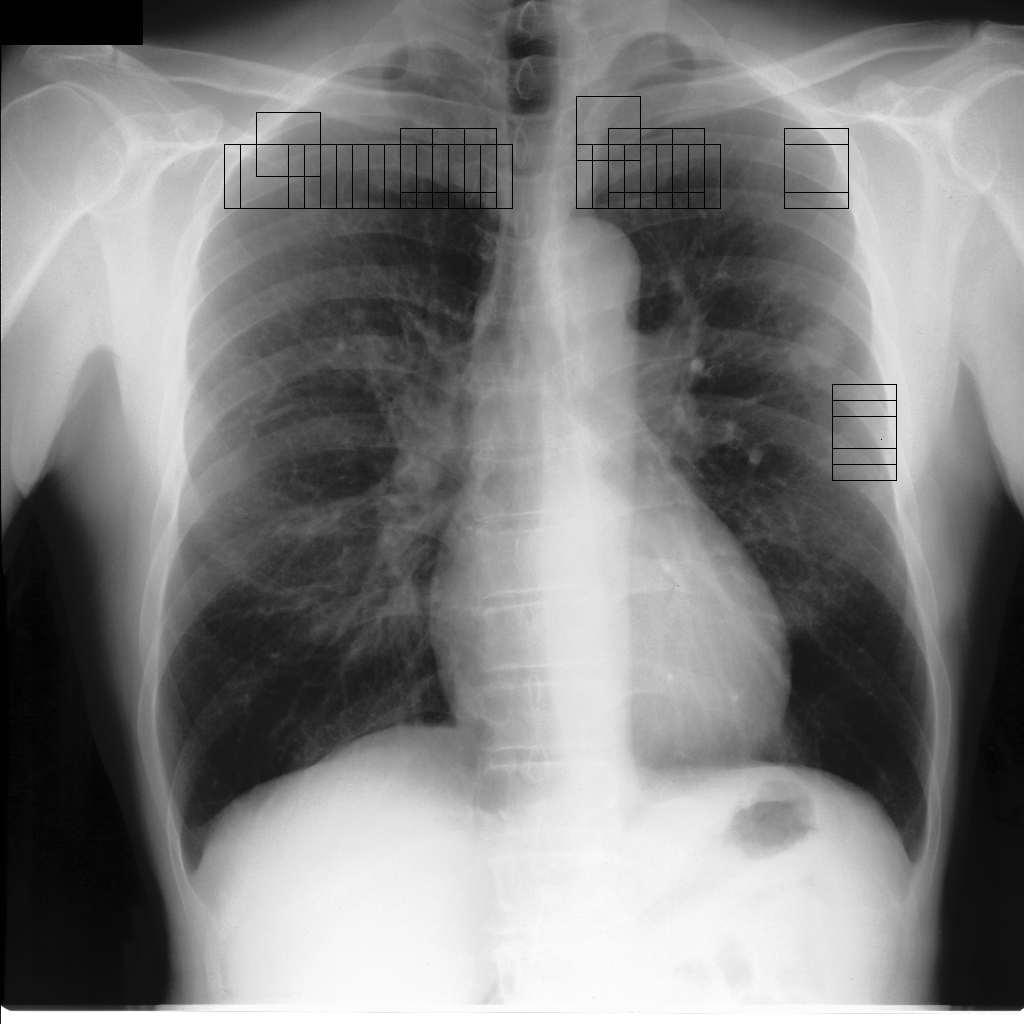

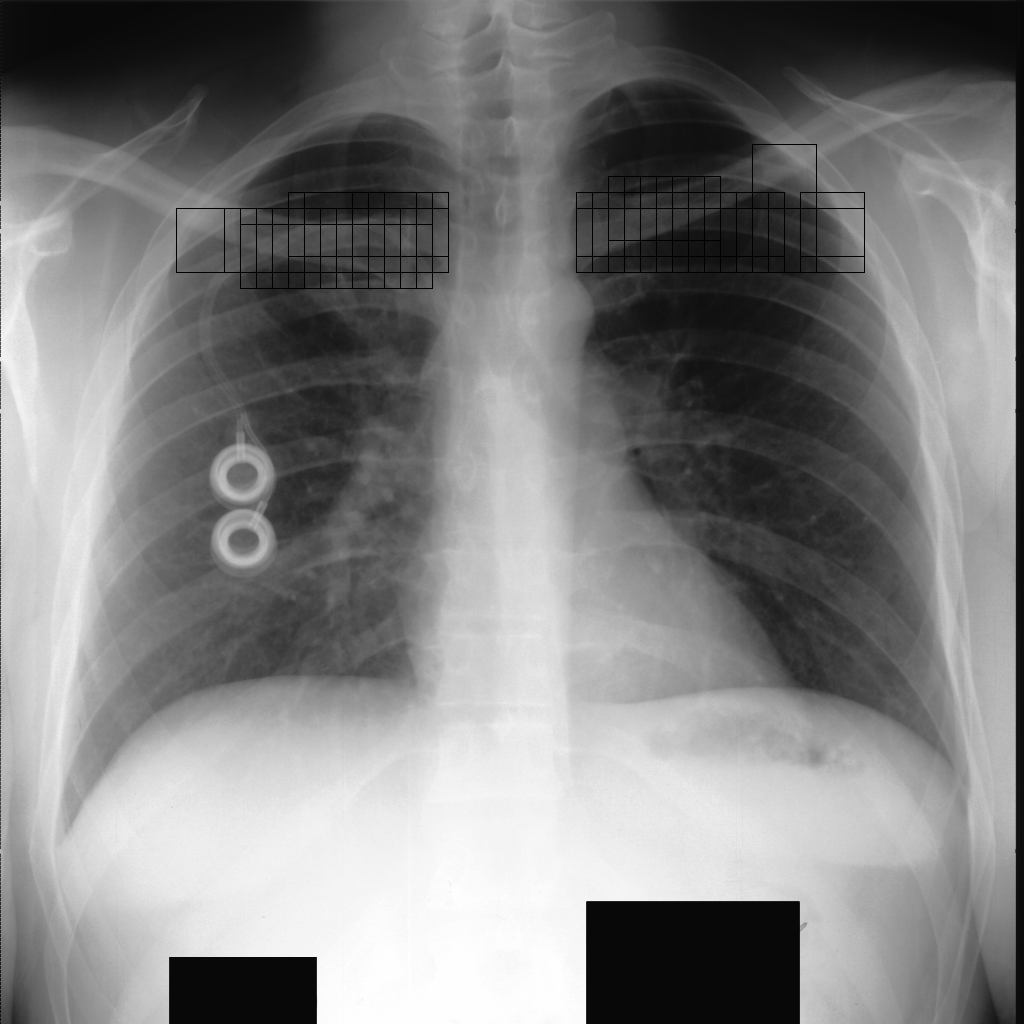

In [127]:
for patient in test_patients:
    patient.display_anon_image()

In [136]:
dataset = datasets.ImageFolder("data/patients/JPCLN001/")
for el in dataset:
    print(el[0].name)

AttributeError: ignored